In [2]:
# find Stopwords for Hinglish- remove min_df,max_df
# Try compressing the songs first and then pass to word2vec
# Trends in songs over the years
# Find the topics on which songs are focused
# 
!pip install wordcloud

In [3]:
import pandas as pd
import numpy as np
import nltk
import gensim 
from gensim.models.phrases import Phrases, Phraser
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict

In [6]:
data=pd.read_csv("data")

In [7]:
data.shape

(3027, 6)

In [8]:
data.head()

,movieName,songName,songSinger,songMusic,songLyricist,songLyrics
0,Bala,Don’t Be Shy,"Badshah, Shalmali Kholgade, Gurdeep Mehendi",Sachin-Jigar,"Mellow D, Badshah","Sun, main hoon thoda sanki\nKarun mann ki\nBab..."
1,Laal Kaptaan,Lahu Ka Rang Kara,Samira Koppikar,Samira Koppikar,Sahib,Morey.. lahu ka rang kara\nMorey lahu ka rang ...
2,Laal Kaptaan,Red Red Najariya,Shreya Ghoshal,Samira Koppikar,Saurabh Jain,"Badnaam shehar, badnaam gully\nIsme har raat h..."
3,Laal Kaptaan,Kaal Kaal,"Brijesh Shandilya, Dino James",Samira Koppikar,Saurabh Jain,"Kaal kaal, kaal kaal, jo sapaat chal raha\nWo ..."
4,Laal Kaptaan,Taandav,"Kailash Kher, Brijesh Shandilya",Samira Koppikar,Puneet Sharma,Shor hai andher mein\nJo dher murda pedon ka\n...


In [10]:
data['songLyrics'][0].split("\n")

['Sun, main hoon thoda sanki',
 'Karun mann ki',
 'Baby gaana lagade thoda funky',
 'Nahi mann ki',
 'Nahi dhan ki',
 'Ye baat hai tere tann ki',
 '',
 'Paagal ho jaaun jab tu ho rubaru',
 'Na lamba ocha gora chitta',
 'Phir bhi dil mein tu',
 'Ishq ne tere kiya hai bekaboo',
 'Jaisa hai waisa hi pasand mujhko tu jaanu',
 '',
 'I just wanna feel your body',
 '(Saanu kare ishaare)',
 'Touch my body',
 "Don't be shy my honey",
 '(Saanu kare ishaare)',
 '',
 'I wanna feel your body',
 '(Saanu kare ishaare)',
 'Touch my body',
 "Don't be shy my honey",
 '(Saanu kare ishaare)',
 'Touch my body',
 'Fly my honey',
 "Don't be shy my honey",
 'Befikar fly my honey',
 "Don't be shy my honey",
 '',
 'Sun, main hoon thoda sanki',
 'Karun mann ki',
 'Baby gaana lagade thoda funky',
 'Nahi mann ki',
 'Nahi dhan ki',
 'Ye baat hai tere tann ki...',
 '',
 'Kuch bhi bole bina',
 'Aankhon se tu baat kare',
 'Ye shaitani jaan bujhke mere saath kare',
 'Tujhko dekhe bina dil mera ab kahin lage nahi',
 'Te

In [6]:
doc=[]
for i in range(data.shape[0]):
    doc.append(nltk.word_tokenize(re.sub('[^a-zA-z\s]','',data['songLyrics'][i].lower())))

# Bag of words approach

In [7]:
strr=""
for i in doc:
    for j in i:
        strr=strr+' '+ j

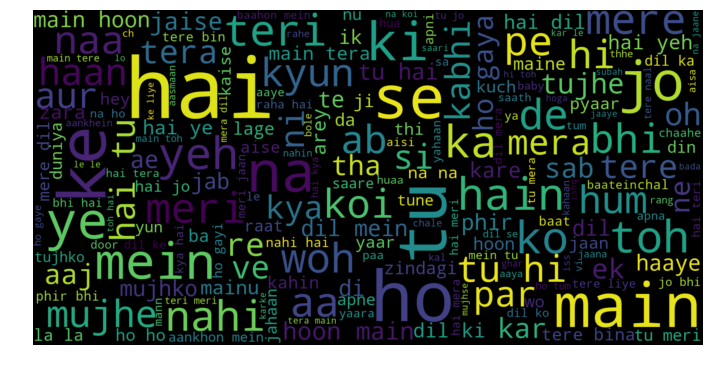

In [8]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(strr)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [9]:
train=[]
for i in doc:
    strr=""
    for j in i:
        strr=strr+' '+j
    train.append(strr)
    

In [10]:
count_vec=CountVectorizer(max_features=10000,ngram_range=(1,3),min_df=0.01,max_df=0.9)
features=count_vec.fit_transform(train)

In [11]:
len(count_vec.get_feature_names())

1470

In [12]:
count_vec.get_feature_names()

['aa',
 'aa aa',
 'aa gaya',
 'aa gayi',
 'aadat',
 'aadha',
 'aadhi',
 'aag',
 'aage',
 'aah',
 'aaj',
 'aaja',
 'aake',
 'aan',
 'aana',
 'aane',
 'aankh',
 'aankhein',
 'aankhen',
 'aankhon',
 'aankhon ke',
 'aankhon ki',
 'aankhon mein',
 'aankhon se',
 'aansu',
 'aao',
 'aap',
 'aarzoo',
 'aas',
 'aashiq',
 'aasmaan',
 'aata',
 'aata hai',
 'aate',
 'aati',
 'aati hai',
 'aaun',
 'aave',
 'aaya',
 'aaya hai',
 'aaye',
 'aayega',
 'aayi',
 'aayi hai',
 'ab',
 'ab na',
 'ab toh',
 'ab tu',
 'abb',
 'abhi',
 'adaa',
 'ae',
 'agar',
 'ai',
 'aisa',
 'aise',
 'aisi',
 'ajj',
 'ajnabi',
 'akh',
 'akhaan',
 'akhiyan',
 'alag',
 'all',
 'allah',
 'am',
 'and',
 'andar',
 'andhera',
 'andhere',
 'apna',
 'apne',
 'apni',
 'are',
 'arey',
 'armaan',
 'arrey',
 'asar',
 'assi',
 'aur',
 'aye',
 'baad',
 'baadal',
 'baahein',
 'baahon',
 'baahon mein',
 'baaki',
 'baal',
 'baap',
 'baaqi',
 'baar',
 'baar baar',
 'baari',
 'baarish',
 'baat',
 'baat hai',
 'baatein',
 'baaton',
 'baaton mein'

In [13]:
sw=count_vec.get_stop_words()

In [14]:
sw

# TF-IDF

In [15]:
tvec = TfidfVectorizer(max_features=50000, ngram_range=(1,3))
featuress=tvec.fit_transform(train)



In [16]:
# tvec.get_feature_names()

# Word2vec

In [65]:
# build vocabulary and train model
w2v_model = gensim.models.Word2Vec(doc,size=300,window=15,min_count=2,workers=10,iter=10)
 

In [66]:
w2v_model.wv.most_similar(positive=["ladki"],topn=30)

[('pagli', 0.7821118235588074),
 ('bhadki', 0.7595430612564087),
 ('hirni', 0.7511991262435913),
 ('bholi', 0.748058021068573),
 ('kiski', 0.7388608455657959),
 ('tikhi', 0.7388180494308472),
 ('nakhrezi', 0.7334308624267578),
 ('uski', 0.7300316095352173),
 ('shaamat', 0.7281936407089233),
 ('hasina', 0.7224459648132324),
 ('tabiyat', 0.6981139183044434),
 ('bolti', 0.6946688890457153),
 ('choti', 0.6923705339431763),
 ('tezi', 0.6907729506492615),
 ('kharaab', 0.6846696138381958),
 ('padti', 0.6836082339286804),
 ('taisi', 0.6815592050552368),
 ('gutli', 0.6792900562286377),
 ('sanwali', 0.677106499671936),
 ('iski', 0.6770094633102417),
 ('komalkomal', 0.6769245862960815),
 ('nagin', 0.6753458976745605),
 ('ladka', 0.6745123863220215),
 ('chull', 0.6695646047592163),
 ('buddhi', 0.6657022833824158),
 ('masti', 0.6637625694274902),
 ('naadaan', 0.6631249189376831),
 ('halki', 0.6612765789031982),
 ('mastani', 0.6612482070922852),
 ('seedhi', 0.6572535037994385)]

In [67]:
w2v_model.wv.most_similar(positive=["maa"])

[('aanchal', 0.6763774156570435),
 ('sehmasehma', 0.6629800200462341),
 ('iski', 0.6402838230133057),
 ('pet', 0.6309642195701599),
 ('baap', 0.6082305908203125),
 ('naachna', 0.6014535427093506),
 ('khudki', 0.5980710387229919),
 ('fauji', 0.595901608467102),
 ('perplex', 0.5905705690383911),
 ('khedaaya', 0.59029221534729)]

In [68]:
w2v_model.wv.most_similar(positive=["papa"])

[('bajaye', 0.7780275344848633),
 ('setting', 0.693885087966919),
 ('waalon', 0.6874403357505798),
 ('nachungi', 0.6846287250518799),
 ('akad', 0.6797761917114258),
 ('footpath', 0.6767768859863281),
 ('daalo', 0.6712957620620728),
 ('naachegi', 0.6646528244018555),
 ('india', 0.6636440753936768),
 ('khench', 0.6584562063217163)]

In [69]:
w2v_model.wv.most_similar(positive=["girl","ladki"])

[('hasina', 0.8013215661048889),
 ('hirni', 0.7869861125946045),
 ('tezi', 0.7866613864898682),
 ('start', 0.7688995599746704),
 ('nakhrezi', 0.7681745290756226),
 ('adayein', 0.7587242126464844),
 ('padti', 0.7565988898277283),
 ('blowing', 0.750407874584198),
 ('chandu', 0.7408386468887329),
 ('jaari', 0.7407184839248657)]

In [70]:
w2v_model.wv.most_similar(positive="disco")

[('khisko', 0.8220754861831665),
 ('tamanche', 0.8025801181793213),
 ('floor', 0.7932847738265991),
 ('limit', 0.7811633944511414),
 ('nasheelee', 0.7743369936943054),
 ('beat', 0.7661519646644592),
 ('baiyaan', 0.7598690986633301),
 ('thumke', 0.7582615613937378),
 ('dynamite', 0.7461631298065186),
 ('anarkali', 0.7436412572860718)]

In [71]:
w2v_model.wv.most_similar(positive="dil")

[('khatara', 0.5460834503173828),
 ('sifarisho', 0.5255773663520813),
 ('dhadke', 0.5221536159515381),
 ('banjara', 0.5191588401794434),
 ('bechara', 0.5142488479614258),
 ('pehal', 0.5131976008415222),
 ('patanga', 0.4994124174118042),
 ('agar', 0.49296894669532776),
 ('badmash', 0.49168843030929565),
 ('lathkhor', 0.49166038632392883)]

In [72]:
w2v_model.wv.similarity(w1="girl",w2="dress")

0.6114609484429677

In [73]:
# model.wv.vocab

In [30]:
# word_freq = defaultdict(int)
# for i in doc:
#     for j in i:
#         word_freq[j] += 1
# len(word_freq)

In [31]:
# sorted(word_freq, key=word_freq.get, reverse=True)[:10]

In [32]:
# w2v_model = gensim.models.Word2Vec(min_count=20,
#                      window=2,
#                      size=300,
#                      sample=6e-5, 
#                      alpha=0.03, 
#                      min_alpha=0.0007, 
#                      negative=20,)
# w2v_model.build_vocab(doc)

In [33]:
# w2v_model.train(doc, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

In [34]:
# w2v_model.wv.most_similar(positive=["ladki"],topn=30)

In [35]:
# w2v_model.wv.doesnt_match(['ladki', 'munda', 'girl'])

In [36]:
# t-SNE Visualization 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.
# For that we are going to use t-SNE implementation from scikit-learn.

In [74]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    plt.show()
    
# To make the visualizations more relevant, we will look at the relationships between a query 
# word (in **red**), its most similar words in the model (in **blue**), 
# and other words from the vocabulary (in **green**).


    

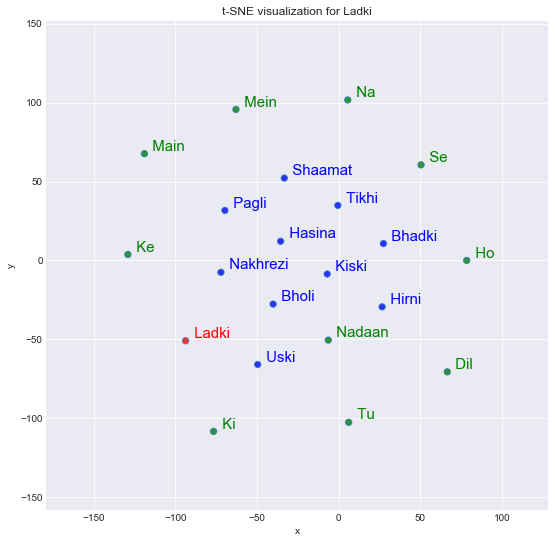

In [75]:
tsnescatterplot(w2v_model, 'ladki', ['nadaan', 'tu', 'main', 'mein', 'ho', 'na', 'ke', 'se', 'ki', 'dil'])

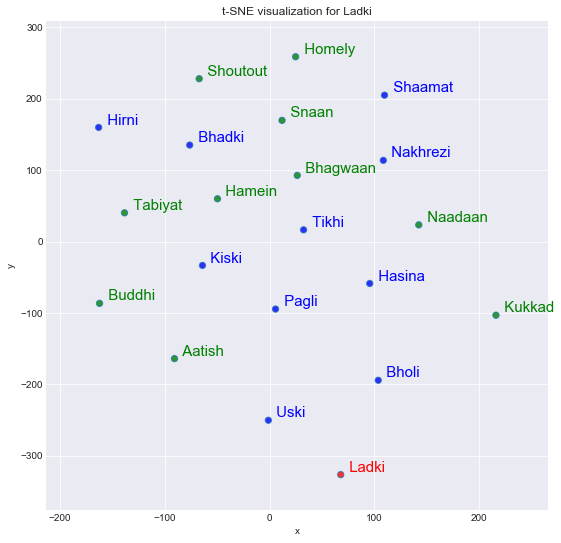

In [76]:
tsnescatterplot(w2v_model, 'ladki', [i[0] for i in w2v_model.wv.most_similar(positive=["ladka"])])

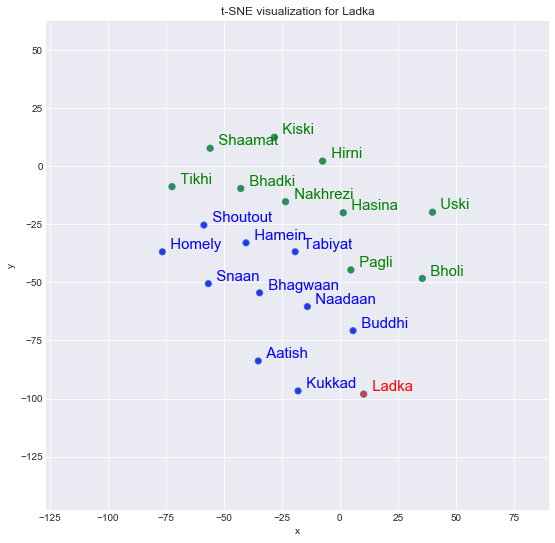

In [77]:
tsnescatterplot(w2v_model, 'ladka', [i[0] for i in w2v_model.wv.most_similar(positive=["ladki"])])

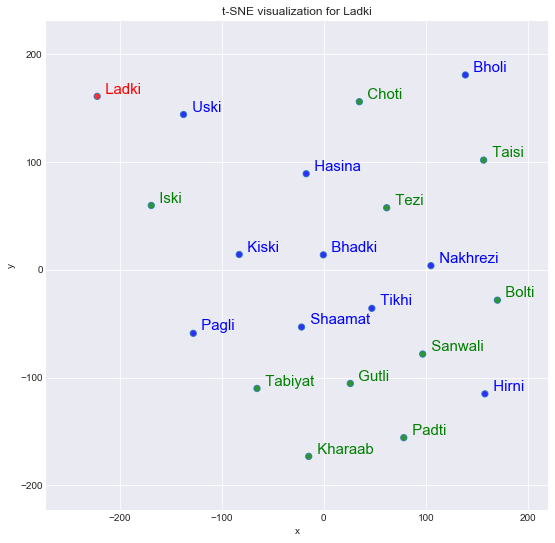

In [78]:
tsnescatterplot(w2v_model, "ladki", [t[0] for t in w2v_model.wv.most_similar(positive=["ladki"], topn=20)][10:])

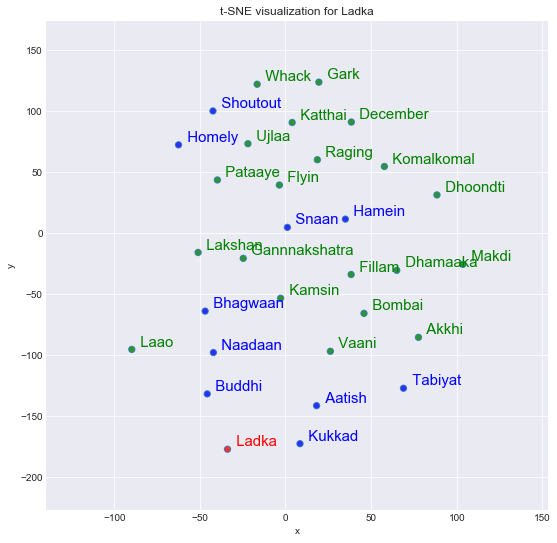

In [79]:
tsnescatterplot(w2v_model, "ladka", [t[0] for t in w2v_model.wv.most_similar(positive=["ladka"], topn=30)][10:])

In [57]:
# finding the window size for the songs
for line in data.songLyrics[246].split("\n"):
    print(line)

Ho yeh khabar chhapwa do akhbaar mein
Poster lagwa do baazaar mein
Ho… yeh khabar chhapwa do akhbaar mein
Ho ek ladka, ek ladki
Ek ladka, ek ladki
Ek ladka ladki, ladka ladki, ladka ladki…
Dhoondne ko pyar mein
Ghooma hoon gali gali
Tu jo mil gayi
Dhoondne ko pyar mein
Ghoomi hoon gali gali
Tu jo mil gaya
Ab jo mile hain tum
Aa ho jayein khalli balli
Yeh na ho phans jaaye
Yeh na ho phans jaaye
Yeh na ho, na ho, na ho… jaaye jaaye…
Akhbaar hua purana baby online de do news
Ki main teri mehbooba
Aur tu hai mera muse
Le le credit card
Tu aaj hi karle choose shadi destination wali
Aajkal tere mere pyaar ke charche
Har jubaan pe chori
Sabko maloom pad gaya
Teri mummy ko nahi tension
Tere papa ka main pension
Tu le le na attention
Chori pagal kyun hori
O yeh khabar chhapwa do akhbaar mein
Poster lagwa do baazaar mein
Yeh khabar chhapwa do akhbaar mein
Haan ek ladka, ek ladki
Ek ladka, ek ladki
Ek ladka ladki, ladka ladki, ladka ladki…
Ho dono paagal ho gaye pyar mein


In [66]:
# Preprocessing function
def songPreprocessing(song):
    listOfWords = re.split(r'[;,\s...\n()\'!?.]\s*',song)
    processedSong = ''
    for word in listOfWords:
        word = word.lower()
        if word == 'x2':
            continue
        if word == 'x4':
            continue
        processedSong+=word
        processedSong+=' '
    return processedSong

averageChorusLength = 0
count = 0
for i in range(0, len(data)):
    count+=1
    averageChorusLengthForSong = 0
    numWords = 0
    chorusCount = 0
#     print(i , " is :  ")
    for line in data.songLyrics[i].split('\n'):
#         print(len(songPreprocessing(line).split(' '))) 
#         print(line)
        numWords+=len(songPreprocessing(line).split(' '))-1
        if(len(line) == 0):
#             print("yes")
            averageChorusLengthForSong+=numWords
            numWords = 0
            chorusCount+=1
    averageChorusLengthForSong/=(chorusCount+1) # account for the last chorus
    if(averageChorusLengthForSong == 0):
        count-=1
        continue
#     print(averageChorusLengthForSong)
    averageChorusLength += averageChorusLengthForSong
    
averageChorusLength/=count
    
print(averageChorusLength)
    
# averageChorusLength/=1
# print(averageChorusLength)

23.667168235914335


### Hence the average optimal window size for the songs is 23.667 or 24 words